In [1]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils, redcells
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
from matplotlib import rcParams
default_font = 12
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange', 'grey'] #rew #nrew #rew_test #nrew_test #GI

In [2]:
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_12_09', 'blk':'2'})
VG14.append({'mname': 'VG14', 'datexp': '2024_12_10', 'blk':'2'})
VG14.append({'mname': 'VG14', 'datexp': '2024_12_19', 'blk':'2'})
VG14.append({'mname': 'VG14', 'datexp': '2024_12_20', 'blk':'2'})

In [5]:
from pathlib import Path
areas = ["V1", "medial", "lateral", "anterior"]
for sess in VG14:
    #Mouse object loading and saving
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True)
    green_channel = Path(fr"Z:\data\PROC\{name}\{date}\{blk}\suite2p")
    m1.isred = redcells.get_redcells(green_channel)
    m1._spks = m1._spks[m1._snr>=.25]
    m1._xpos = m1._xpos[m1._snr>=.25]
    m1._ypos = m1._ypos[m1._snr>=.25]
    m1._iplane = m1._iplane[m1._snr>=.25]
    m1.iarea = m1.iarea[m1._snr>=.25]
    m1.iregion = m1.iregion[m1._snr>=.25]
    m1.xy_t = m1.xy_t[m1._snr>=.25]
    m1.isred = m1.isred[m1._snr>=.25]
    frameselector = utils.get_frameselector(m1)
    istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
    istim_df["trial_no"] = np.arange(1, len(istim_df)+1).astype(float)
    m1.frameselector = (frameselector.reset_index()
        .rename(columns = {'index':'frame'})
        .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
        .set_index('frame'))
    m1.trial_dict = utils.get_trialno_bytype(m1.frameselector)
    m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = False, corridor_length=400)
    m1.interp_spks = m1.interp_spks - m1.interp_spks.mean(1, keepdims=True)
    utils.compute_dprime(m1, discrimination_region=(0,125), concatenate=False, remove_mean=False)
    mdl_save_path = Path(f"D:/mouseobj/notz/allrew/{name}/{date}/{blk}")
    if not mdl_save_path.exists():
        mdl_save_path.mkdir(parents=True)
    utils.save_mouse(m1,compressed=False, mdl_path=mdl_save_path)
    #Analysis
    ntrials = m1.interp_spks.shape[1]
    ncells = m1.interp_spks.shape[0]
    cod_dirs = np.empty((ntrials, 2, len(areas), 400))
    proportion = np.empty((len(areas), 2, 2))
    selective_cells = np.empty((4,2,2, ncells))
    main_dir = Path(f"../data/notz/allrew/{name}/{date}/{blk}")
    if not main_dir.exists():
        main_dir.mkdir(parents=True)
    for indexa, area in enumerate(areas):
        ia = utils.get_region_idx(m1.iarea, area)
        for redcell in range(2):
            if redcell == 0: 
                selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
            else:
                selected_type = m1.isred[:,0].astype(bool)
            pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
            prefer_r = (m1.train_dp>=pstv_tsh)
            prefer_nr = (m1.train_dp<=ngtv_tsh)
            area_prefer_r = prefer_r * ia * selected_type
            area_prefer_nr = prefer_nr * ia * selected_type
            dir_for_type = m1.interp_spks 
            dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
            avg_dir = dir_for_type.mean(0)
            cod_dirs[:, redcell, indexa, :] = avg_dir
            selective_cells[indexa, redcell, 0, :] = area_prefer_r
            selective_cells[indexa, redcell, 1, :] = area_prefer_nr
            # proportion of cells changing 
            prefer_r_1 = (m1.train_dp>=1)
            prefer_nr_1 = (m1.train_dp<=-1)
            area_prefer_r_1 = prefer_r_1 * ia * selected_type
            area_prefer_nr_1 = prefer_nr_1 * ia * selected_type
            proportion[indexa,redcell,0] = (area_prefer_r_1.sum()) / (ia * selected_type).sum()
            proportion[indexa,redcell,1] = (area_prefer_nr_1.sum()) / (ia * selected_type).sum()
    np.save(main_dir / "cod_dirs_0_125.npy", cod_dirs)
    np.save(main_dir / "selective_cells_0_125.npy", selective_cells)
    np.save(main_dir / "proportion_cells_0_125_1tsh.npy", proportion)
    np.save(main_dir / "trial_no_dir.npy", m1.trial_dict)

Checking if model object exists ...
Timeline with fname: Timeline_VG14_2024_12_09_2.mat not found, trying with fname: VG14_2024_12_09_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [08:24<00:00, 25.23s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG14_2024_12_09_2_behav.npz
(38126, 2)
161 19685
interpolating 33089 neurons, 19525 frames to
the vector of distance with shape: (19525,)
neurons: 33089, trials: 200, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Creating directory D:\mouseobj\notz\allrew\VG14\2024_12_09\2\VG14\2024_12_09\2
Mouse object saved to D:\mouseobj\notz\allrew\VG14\2024_12_09\2\VG14\2024_12_09\2
Checking if model object exists ...
Timeline with fname: Timeline_VG14_2024_12_10_2.mat not found, trying with fname: VG14_2024_12_10_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [06:43<00:00, 20.17s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG14_2024_12_10_2_behav.npz
(33786, 2)
40 11761
interpolating 28675 neurons, 11722 frames to
the vector of distance with shape: (11722,)
neurons: 28675, trials: 281, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Creating directory D:\mouseobj\notz\allrew\VG14\2024_12_10\2\VG14\2024_12_10\2
Mouse object saved to D:\mouseobj\notz\allrew\VG14\2024_12_10\2\VG14\2024_12_10\2
Checking if model object exists ...
Timeline with fname: Timeline_VG14_2024_12_19_2.mat not found, trying with fname: VG14_2024_12_19_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [08:22<00:00, 25.15s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG14_2024_12_19_2_behav.npz
(35170, 2)
40 24310
interpolating 29415 neurons, 24271 frames to
the vector of distance with shape: (24271,)
neurons: 29415, trials: 388, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Creating directory D:\mouseobj\notz\allrew\VG14\2024_12_19\2\VG14\2024_12_19\2
Mouse object saved to D:\mouseobj\notz\allrew\VG14\2024_12_19\2\VG14\2024_12_19\2
Checking if model object exists ...
Timeline with fname: Timeline_VG14_2024_12_20_2.mat not found, trying with fname: VG14_2024_12_20_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [09:09<00:00, 27.48s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG14_2024_12_20_2_behav.npz
(41600, 2)
40 19498
interpolating 32651 neurons, 19459 frames to
the vector of distance with shape: (19459,)
neurons: 32651, trials: 310, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Creating directory D:\mouseobj\notz\allrew\VG14\2024_12_20\2\VG14\2024_12_20\2
Mouse object saved to D:\mouseobj\notz\allrew\VG14\2024_12_20\2\VG14\2024_12_20\2


In [15]:
from scipy.stats import sem

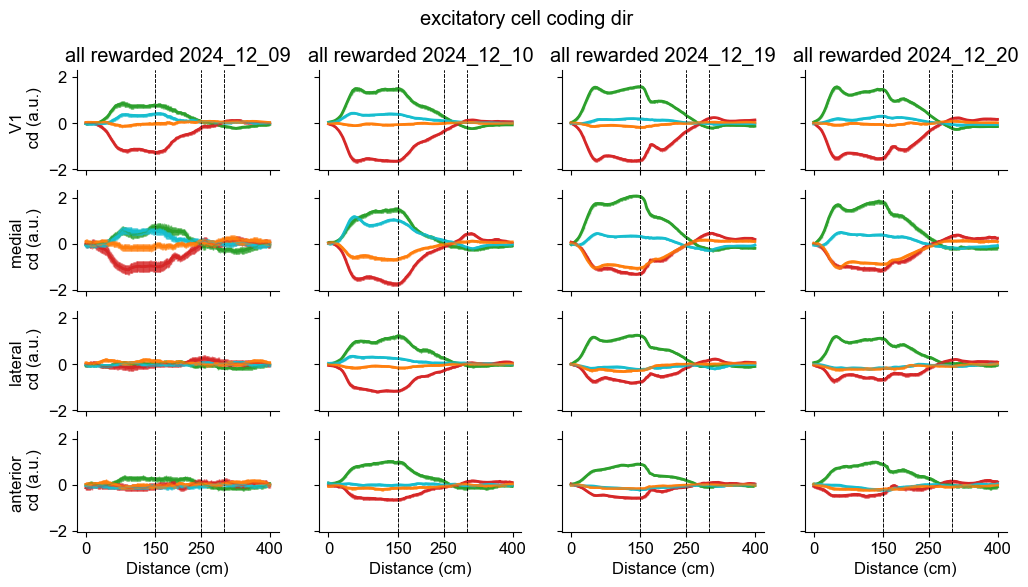

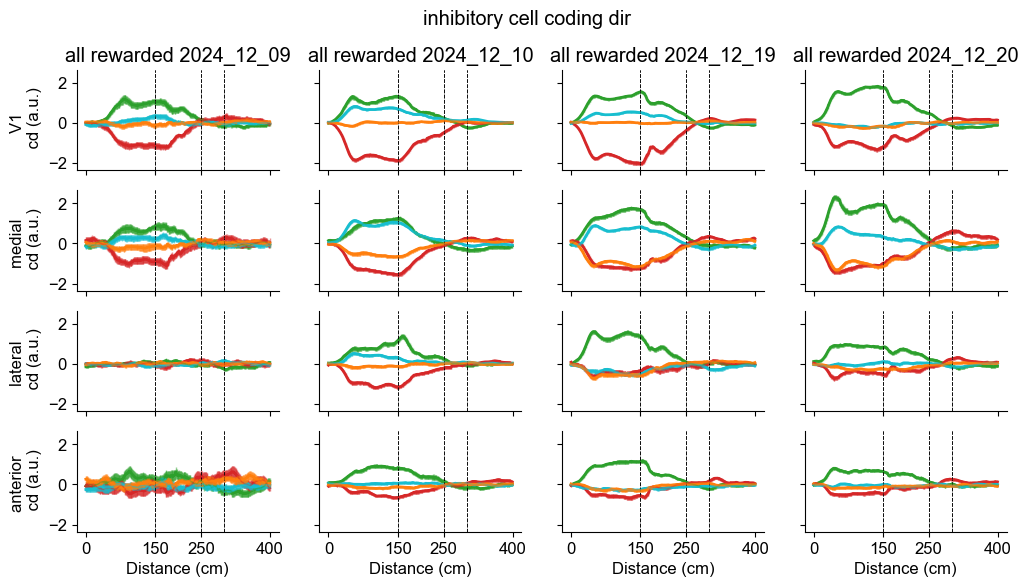

In [20]:
for cell_type in range(2):
    fig, ax = plt.subplots(4,4, figsize=(12,6), sharey=True, sharex=True)
    if cell_type == 0:
        fig.suptitle('excitatory cell coding dir', y=0.98)
    else:
        fig.suptitle('inhibitory cell coding dir', y=0.98)
    for iss, sess in enumerate(VG14):
        name = sess['mname']
        date = sess['datexp']
        blk = sess['blk']
        cdpth = Path(fr"..\data\notz\allrew\{name}\{date}\{blk}\cod_dirs_0_125.npy")
        trialpth = Path(fr"..\data\notz\allrew\{name}\{date}\{blk}\trial_no_dir.npy")
        cdir = np.load(cdpth)
        trial_dict = np.load(trialpth, allow_pickle=True).item()
        ax[0, iss].set_title(f"all rewarded {date}", loc='center')
        ax[3, iss].set_xlabel('Distance (cm)')
        ax[3, iss].set_xticks([0, 150, 250, 400])
        for i_t, (ttype, trials) in enumerate(trial_dict.items()): 
            if ttype in ['rewarded', 'non rewarded']:    
                trials = trials[1::2] # odd trials only
                dir_trial = cdir[trials]
                avg_dir_trial = dir_trial.mean(0)
            else:
                dir_trial = cdir[trials]
                avg_dir_trial = dir_trial.mean(0)
            for ia, area in enumerate(areas):
                ax[ia, 0].set_ylabel(f'{areas[ia]} \n cd (a.u.)')
                ax[ia, iss].plot(np.arange(0,400), avg_dir_trial[cell_type, ia, :], color=trial_type_palette[i_t], linewidth=2)
                ax[ia, iss].errorbar(np.arange(0,400), avg_dir_trial[cell_type, ia, :], yerr=sem(dir_trial[:,cell_type, ia, :]), color=trial_type_palette[i_t], linewidth=1, alpha=0.5)
                ax[ia, iss].axvline(x=150, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
                ax[ia, iss].axvline(x=250, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
                ax[ia, iss].axvline(x=300, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)